In [1]:
import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import warnings, os, gc, joblib
from pprint import pprint
import lightgbm as lgb
from sklearn import metrics
from functools import reduce
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
)
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    GridSearchCV,
    StratifiedGroupKFold,
)
from contextlib import suppress

In [2]:
pathway = ""


def set_table_dtypes(df: pl.DataFrame) -> pl.DataFrame:
    for col in df.columns:
        # Cast Transform DPD (Days past due, P) and Transform Amount (A) as Float64
        if col[-1] in ("P", "A"):
            df = df.with_columns(pl.col(col).cast(pl.Float64).alias(col))
        # Cast Transform date (D) as Date, causes issues with other columns ending in D
        # if col[-1] in ("D"):
        # df = df.with_columns(pl.col(col).cast(pl.Date).alias(col))
        # Cast aggregated columns as Float64, tried combining sum and max, but did not work correctly
        if col[-4:-1] in ("_sum"):
            df = df.with_columns(pl.col(col).cast(pl.Float64).alias(col))
        if col[-4:-1] in ("_max"):
            df = df.with_columns(pl.col(col).cast(pl.Float64).alias(col))
    return df


def convert_strings(df: pl.DataFrame) -> pl.DataFrame:
    for col in df.columns:
        if df[col].dtype == pl.Utf8:
            df = df.with_columns(pl.col(col).cast(pl.Categorical))
    return df


# Changed this function to work for Pandas
def missing_values(df, threshold=0.0):
    missing_cols = []
    for col in df.columns:
        decimal = (pd.isnull(df[col]).sum()) / (len(df[col]))
        if decimal > threshold:
            print(f"{col}: {decimal}")
            missing_cols.append(col)
    return missing_cols


# Impute numeric columns with the median and cat with mode
def imputer(df: pd.DataFrame) -> pd.DataFrame:
    for col in df.columns:
        if df[col].dtype == "float64":
            df[col] = df[col].fillna(df[col].median())
        if df[col].dtype.name in ["category", "object"] and df[col].isnull().any():
            mode_without_nan = df[col].dropna().mode().values[0]
            df[col] = df[col].fillna(mode_without_nan)
    return df

In [3]:
train = (
    pl.read_csv("train_final_final.csv").pipe(set_table_dtypes).pipe(convert_strings)
)

In [4]:
test = pl.read_csv("test_final_final.csv").pipe(set_table_dtypes).pipe(convert_strings)

In [5]:
# change train and test to pandas
train = train.to_pandas()
test = test.to_pandas()

In [6]:
y = train.loc[:, "target"].to_frame("target")
X = train.drop(
    [
        "target",
    ],
    axis=1,
)

# Do not include case_id, or week_num as numeric
numeric_cols = test.select_dtypes(include=["number"]).columns.tolist()
numeric_cols.remove("case_id")
numeric_cols.remove("WEEK_NUM")


# scale values before passing on to model
warnings.filterwarnings("ignore")
scaler = MinMaxScaler(copy=False)
X[numeric_cols] = scaler.fit_transform(X[numeric_cols])
test[numeric_cols] = scaler.transform(test[numeric_cols])

# Drop case_id and week_num from features
weeks = X["WEEK_NUM"]
X_feats = X.drop(["case_id", "WEEK_NUM"], axis=1)

# Sort columns in alphabetical order for training so columns match test submission
X_feats = X_feats.reindex(sorted(X_feats.columns), axis=1)

In [7]:
def gini_stability(base, w_fallingrate=88.0, w_resstd=-0.5):
    gini_in_time = (
        base.loc[:, ["WEEK_NUM", "target", "score"]]
        .sort_values("WEEK_NUM")
        .groupby("WEEK_NUM")[["target", "score"]]
        .apply(lambda x: 2 * roc_auc_score(x["target"], x["score"]) - 1)
        .tolist()
    )

    x = np.arange(len(gini_in_time))
    y = gini_in_time
    a, b = np.polyfit(x, y, 1)
    y_hat = a * x + b
    residuals = y - y_hat
    res_std = np.std(residuals)
    avg_gini = np.mean(gini_in_time)
    return avg_gini + w_fallingrate * min(0, a) + w_resstd * res_std

In [8]:
# remove categorical columns from X_feats
X_feats = X_feats.select_dtypes(include=["number"])

In [9]:
X_train, X_valid, y_train, y_valid, weeks_train, weeks_valid = train_test_split(
    X_feats, y, weeks, test_size=0.2, random_state=42
)

In [10]:
# fit a random forest model

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_train_pred = rf.predict_proba(X_train)[:, 1]
y_valid_pred = rf.predict_proba(X_valid)[:, 1]

In [11]:
# AUC score for train and validation sets

rf_train_auc = roc_auc_score(y_train, y_train_pred)
rf_valid_auc = roc_auc_score(y_valid, y_valid_pred)

print(f"Train AUC: {rf_train_auc:.4f}")
print(f"Validation AUC: {rf_valid_auc:.4f}")

Train AUC: 1.0000
Validation AUC: 0.7895


In [12]:
base_train = pd.concat([X_train, y_train], axis=1)
base_train["score"] = rf.predict_proba(X_train)[:, 1]

base_valid = pd.concat([X_valid, y_valid], axis=1)
base_valid["score"] = rf.predict_proba(X_valid)[:, 1]

In [13]:
# get indices of the train and validation sets

idx_train = base_train.index
idx_valid = base_valid.index

In [14]:
base_train["WEEK_NUM"] = weeks.iloc[idx_train]
base_valid["WEEK_NUM"] = weeks.iloc[idx_valid]


rf_stability_score_train = gini_stability(base_train)
print(f"The stability score on the train set is: {rf_stability_score_train}")

rf_stability_score_valid = gini_stability(base_valid)
print(f"The stability score on the valid set is: {rf_stability_score_valid}")

The stability score on the train set is: 0.9999999999999993
The stability score on the valid set is: 0.5359444695892717


In [15]:
# do the same as above for catboost

from catboost import CatBoostClassifier

cb = CatBoostClassifier(iterations=100, learning_rate=0.1, depth=6, verbose=0)

cb.fit(X_train, y_train)

In [16]:
y_train_pred = cb.predict_proba(X_train)[:, 1]

y_valid_pred = cb.predict_proba(X_valid)[:, 1]

cb_train_auc = roc_auc_score(y_train, y_train_pred)

cb_valid_auc = roc_auc_score(y_valid, y_valid_pred)

print(f"Train AUC: {cb_train_auc:.4f}")

print(f"Validation AUC: {cb_valid_auc:.4f}")

base_train = pd.concat([X_train, y_train], axis=1)

base_train["score"] = cb.predict_proba(X_train)[:, 1]

base_valid = pd.concat([X_valid, y_valid], axis=1)

base_valid["score"] = cb.predict_proba(X_valid)[:, 1]

idx_train = base_train.index

idx_valid = base_valid.index

base_train["WEEK_NUM"] = weeks.iloc[idx_train]

base_valid["WEEK_NUM"] = weeks.iloc[idx_valid]

cb_stability_score_train = gini_stability(base_train)

print(f"The stability score on the train set is: {cb_stability_score_train}")

cb_stability_score_valid = gini_stability(base_valid)

print(f"The stability score on the valid set is: {cb_stability_score_valid}")

Train AUC: 0.8195
Validation AUC: 0.8167
The stability score on the train set is: 0.6163383827291512
The stability score on the valid set is: 0.5998108715692682


In [17]:
# train XGBoost model

from xgboost import XGBClassifier

xgb = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)

xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [18]:
y_train_pred = xgb.predict_proba(X_train)[:, 1]

y_valid_pred = xgb.predict_proba(X_valid)[:, 1]

xgb_train_auc = roc_auc_score(y_train, y_train_pred)

xgb_valid_auc = roc_auc_score(y_valid, y_valid_pred)

print(f"Train AUC: {xgb_train_auc:.4f}")

print(f"Validation AUC: {xgb_valid_auc:.4f}")

base_train = pd.concat([X_train, y_train], axis=1)

base_train["score"] = xgb.predict_proba(X_train)[:, 1]

base_valid = pd.concat([X_valid, y_valid], axis=1)

base_valid["score"] = xgb.predict_proba(X_valid)[:, 1]

idx_train = base_train.index

idx_valid = base_valid.index

base_train["WEEK_NUM"] = weeks.iloc[idx_train]

base_valid["WEEK_NUM"] = weeks.iloc[idx_valid]

xgb_stability_score_train = gini_stability(base_train)

print(f"The stability score on the train set is: {xgb_stability_score_train}")

xgb_stability_score_valid = gini_stability(base_valid)

print(f"The stability score on the valid set is: {xgb_stability_score_valid}")

Train AUC: 0.8511
Validation AUC: 0.8264
The stability score on the train set is: 0.6888318342805547
The stability score on the valid set is: 0.6141054151916016


In [19]:
# lgbm

lgbm = lgb.LGBMClassifier(
    n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42
)

lgbm.fit(X_train, y_train)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 32660, number of negative: 998567
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.155378 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 31333
[LightGBM] [Info] Number of data points in the train set: 1031227, number of used features: 189
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.031671 -> initscore=-3.420170
[LightGBM] [Info] Start training from score -3.420170


LGBMClassifier(max_depth=6, random_state=42)

In [20]:
X_train

,actualdpd_943P_sum,actualdpdtolerance_344P,amount_4917619A_sum,amtinstpaidbefduel24m_4187115A,annuity_780A,annuity_853A_sum,annuitynextmonth_57A,applicationcnt_361L,applications30d_658L,applicationscnt_1086L,...,sellerplacecnt_915L,sellerplacescnt_216L,sumoutstandtotal_3546847A,sumoutstandtotalest_4493215A,tenor_203L_sum,thirdquarter_1082L,totalamount_6A_sum,totaldebt_9A,totalsettled_863A,totinstallast1m_4525188A
685191,0.0,0.0,0.040698,0.021135,0.060246,0.064241,0.000000,0.0,0.035714,0.0,...,0.125,0.039216,0.020267,0.02256,0.043333,0.032258,0.000039,0.000000,0.003322,0.011441
307308,0.0,0.0,0.040698,0.021135,0.029198,0.026474,0.000000,0.0,0.000000,0.0,...,0.125,0.019608,0.020267,0.02256,0.100000,0.032258,0.000000,0.000000,0.000000,0.011441
397388,0.0,0.0,0.040698,0.021135,0.041246,0.023797,0.000000,0.0,0.000000,0.0,...,0.000,0.000000,0.020267,0.02256,0.040000,0.000000,0.000150,0.000000,0.000000,0.011441
729474,0.0,0.0,0.040698,0.052057,0.033504,0.078692,0.053134,0.0,0.000000,0.0,...,0.000,0.068627,0.027778,0.02256,0.100000,0.000000,0.000000,0.007666,0.010212,0.011441
259429,0.0,0.0,0.040698,0.021135,0.032655,0.028821,0.000000,0.0,0.000000,0.0,...,0.000,0.000000,0.020267,0.02256,0.075000,0.032258,0.000039,0.000000,0.000000,0.011441
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110268,0.0,0.0,0.040698,0.000000,0.042813,0.029870,0.000000,0.0,0.000000,0.0,...,0.000,0.000000,0.020267,0.02256,0.035833,0.032258,0.000006,0.000000,0.000349,0.011441
259178,0.0,0.0,0.040698,0.021135,0.016113,0.004542,0.025127,0.0,0.000000,0.0,...,0.125,0.009804,0.045172,0.02256,0.013333,0.032258,0.000000,0.025420,0.000106,0.011441
131932,0.0,0.0,0.040698,0.093363,0.028414,0.123027,0.000000,0.0,0.000000,0.0,...,0.000,0.068627,0.020267,0.02256,0.560000,0.161290,0.000067,0.000000,0.004430,0.011441
671155,0.0,0.0,0.040698,0.021135,0.105385,0.124492,0.000000,0.0,0.000000,0.0,...,0.000,0.049020,0.020267,0.02256,0.126667,0.064516,0.000000,0.000000,0.006091,0.011441


In [21]:
y_train_pred = lgbm.predict_proba(X_train)[:, 1]

y_valid_pred = lgbm.predict_proba(X_valid)[:, 1]

lgbm_train_auc = roc_auc_score(y_train, y_train_pred)

lgbm_valid_auc = roc_auc_score(y_valid, y_valid_pred)

print(f"Train AUC: {lgbm_train_auc:.4f}")

print(f"Validation AUC: {lgbm_valid_auc:.4f}")

base_train = pd.concat([X_train, y_train], axis=1)

base_train["score"] = lgbm.predict_proba(X_train)[:, 1]

base_valid = pd.concat([X_valid, y_valid], axis=1)

base_valid["score"] = lgbm.predict_proba(X_valid)[:, 1]

idx_train = base_train.index

idx_valid = base_valid.index

base_train["WEEK_NUM"] = weeks.iloc[idx_train]

base_valid["WEEK_NUM"] = weeks.iloc[idx_valid]

lgbm_stability_score_train = gini_stability(base_train)

print(f"The stability score on the train set is: {lgbm_stability_score_train}")

lgbm_stability_score_valid = gini_stability(base_valid)

print(f"The stability score on the valid set is: {lgbm_stability_score_valid}")

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Train AUC: 0.8439
Validation AUC: 0.8249
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
The stability score on the train set is: 0.670937850258859
The stability score on the valid set is: 0.6105473277496015


In [23]:
# is it possible to make a dataframe for the stability scores and AUC of all models?

# stability_scores = pd.DataFrame({
#     'Model': ['Random Forest', 'CatBoost', 'XGBoost', 'LightGBM'],
#     'Train Stability': [gini_stability(base_train), gini_stability(base_train), gini_stability(base_train), gini_stability(base_train)],
#     'Validation Stability': [gini_stability(base_valid), gini_stability(base_valid), gini_stability(base_valid), gini_stability(base_valid)],
#     'Train AUC': [
#         roc_auc_score(y_train, rf.predict_proba(X_train)[:, 1]),
#         roc_auc_score(y_train, cb.predict_proba(X_train)[:, 1]),
#         roc_auc_score(y_train, xgb.predict_proba(X_train)[:, 1]),
#         roc_auc_score(y_train, lgbm.predict_proba(X_train)[:, 1]),
#     ],

#     'Validation AUC': [
#         roc_auc_score(y_valid, rf.predict_proba(X_valid)[:, 1]),
#         roc_auc_score(y_valid, cb.predict_proba(X_valid)[:, 1]),
#         roc_auc_score(y_valid, xgb.predict_proba(X_valid)[:, 1]),
#         roc_auc_score(y_valid, lgbm.predict_proba(X_valid)[:, 1]),
#     ]

# })

# is it possible to make a dataframe for the stability scores and AUC of all models?

stability_scores = pd.DataFrame(
    {
        "Model": ["Random Forest", "CatBoost", "XGBoost", "LightGBM"],
        "Train Stability": [
            rf_stability_score_train,
            cb_stability_score_train,
            xgb_stability_score_train,
            lgbm_stability_score_train,
        ],
        "Validation Stability": [
            rf_stability_score_valid,
            cb_stability_score_valid,
            xgb_stability_score_valid,
            lgbm_stability_score_valid,
        ],
        "Train AUC": [rf_train_auc, cb_train_auc, xgb_train_auc, lgbm_train_auc],
        "Validation AUC": [rf_valid_auc, cb_valid_auc, xgb_valid_auc, lgbm_valid_auc],
    }
)

stability_scores

,Model,Train Stability,Validation Stability,Train AUC,Validation AUC
0,Random Forest,1.000000,0.535944,1.000000,0.789469
1,CatBoost,0.616338,0.599811,0.819543,0.816737
2,XGBoost,0.688832,0.614105,0.851098,0.826363
3,LightGBM,0.670938,0.610547,0.843899,0.824867



Model	Train Stability	Validation Stability	Train AUC	Validation AUC
0	Random Forest	1.000000	0.535944	1.000000	0.789469
1	CatBoost	0.616338	0.599811	0.819543	0.816737
2	XGBoost	0.688832	0.614105	0.851098	0.826363
3	LightGBM	0.670938	0.610547	0.843899	0.824867

In [2]:
import pandas as pd

data = {
    "Model": ["Random Forest", "CatBoost", "XGBoost", "LightGBM"],
    "Train Stability": [1.000000, 0.616338, 0.688832, 0.670938],
    "Validation Stability": [0.535944, 0.599811, 0.614105, 0.631547],
    "Train AUC": [1.000000, 0.819543, 0.851098, 0.843899],
    "Validation AUC": [0.789469, 0.816737, 0.826363, 0.824867],
}

df = pd.DataFrame(data)

In [6]:
df

,Model,Train Stability,Validation Stability,Train AUC,Validation AUC
0,Random Forest,1.000000,0.535944,1.000000,0.789469
1,CatBoost,0.616338,0.599811,0.819543,0.816737
2,XGBoost,0.688832,0.614105,0.851098,0.826363
3,LightGBM,0.670938,0.631547,0.843899,0.824867


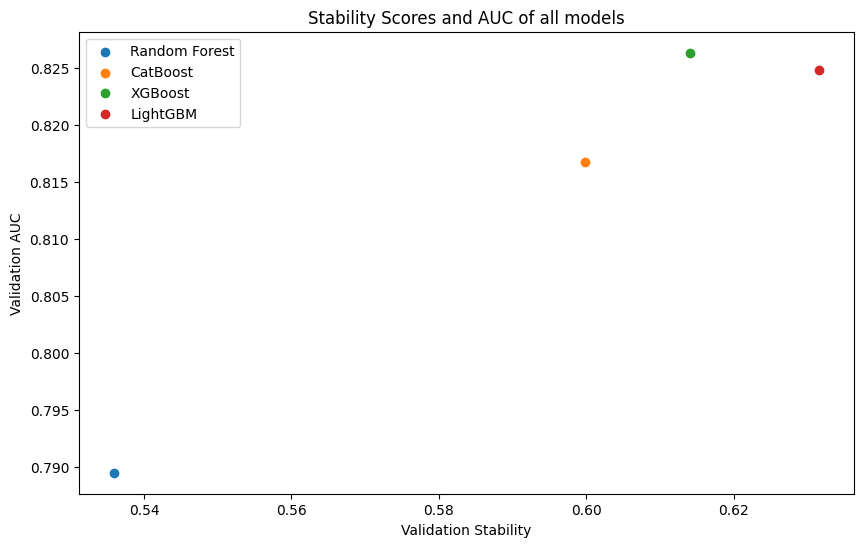

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

for model in df["Model"].unique():
    model_data = df[df["Model"] == model]
    plt.scatter(
        model_data["Validation Stability"],
        model_data["Validation AUC"],
        marker="o",
        label=model,
    )

plt.title("Stability Scores and AUC of all models")
plt.xlabel("Validation Stability")
plt.ylabel("Validation AUC")
plt.legend()
plt.show()